## Import libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # for split data into trainging, validation and testing
from sklearn.preprocessing import LabelEncoder # for encoding categorical features to numerical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report # for Evaluation

## Show downloaded data

In [6]:
df = pd.read_csv("archive/heart.csv")
print(df.head())  # Show the first few rows

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


## Encoding Categorical features

In [9]:
# Identify categorical features
categorical_features = [col for col in df.columns if not np.issubdtype(df[col].dtype, np.number) and col != "HeartDisease"]

# Create encoders for categorical features
encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_features}

# Encode categorical features in training data
for col in categorical_features:
    df[col] = encoders[col].transform(df[col])
    
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


## Split data into trainging, validation and test sets

In [12]:
# Step 1: Split 70% training, 30% temp (validation + test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42) # using random_state(42) to garantie same splitting data

# Step 2: Split temp into 10% validation and 20% test
val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42)

# Print dataset sizes
print(f"Total dataset: {len(df)} samples")
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Testing set: {len(test_df)} samples")

Total dataset: 918 samples
Training set: 642 samples
Validation set: 92 samples
Testing set: 184 samples


## Decision tree implementation

In [15]:
class Node:
    """Node to identify if it is internal node to split or leaf node to predict"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label

    @classmethod
    def leaf(cls, label):
        return cls(label = label)

In [17]:
class DecisionTree:
    def __init__(self, max_depth = None):
        self.max_depth = max_depth
        self.tree = None

    def entropy(self, y):
        """Compute the entropy (H)"""
        # Count 0s, and 1s
        _, counts = np.unique(y, return_counts = True)
        # Compute probabilities of 0s, and 1s
        probs = counts / counts.sum()
        # Get the entropy
        return -np.sum(probs * np.log2(probs + 1e-9)) # Adding small number to avoid log of zero

    def information_gain(self, y, left_split, right_split):
        """Compute information gain (IG)"""
        # Compute H(Y)
        H_Y = self.entropy(y)
        # Compute H(Y|X = left)
        H_Y_left = self.entropy(y[left_split])
        # Compute H(Y|X = right)
        H_Y_right = self.entropy(y[right_split])
        # Compute H(Y|X)
        H_Y_X = (np.sum(left_split) / len(y)) * H_Y_left + (np.sum(right_split) / len(y)) * H_Y_right
        # Get the information gain
        return H_Y - H_Y_X

    def best_split(self, X, y):
        """Find the best numerical split"""
        best_feature, best_threshold, best_IG = None, None, 0
        best_left_split, best_right_split = None, None

        for feature in range(X.shape[1]):  # Iterate over features
            unique_values = np.sort(np.unique(X[:, feature])) # Sort feature values
            # Try splitting at midpoints between consecutive values
            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2  # Midpoint
                left_split = X[:, feature] <= threshold
                right_split = X[:, feature] > threshold

                if np.sum(left_split) == 0 or np.sum(right_split) == 0:
                    continue  # Skip invalid splits

                IG = self.information_gain(y, left_split, right_split)
                if IG > best_IG:
                    best_IG, best_feature, best_threshold = IG, feature, threshold
                    best_left_split, best_right_split = left_split, right_split

        return best_feature, best_threshold, best_left_split, best_right_split

    def build_tree(self, X, y, depth=0):
        """Recursively build the decision tree using threshold splits."""
        if len(set(y)) == 1:  # If only one class, return leaf node
            return Node.leaf(y[0])

        if self.max_depth and depth >= self.max_depth:
            return Node.leaf(np.bincount(y).argmax())  # Return most common label

        feature, threshold, left_split, right_split = self.best_split(X, y)

        if feature is None:
            return  Node.leaf(np.bincount(y).argmax())  # No valid split

        # Recursively build left and right subtrees
        left_subtree = self.build_tree(X[left_split, :], y[left_split], depth + 1)
        right_subtree = self.build_tree(X[right_split, :], y[right_split], depth + 1)

        
        return Node(feature, threshold, left_subtree, right_subtree)

    def fit(self, X, y):
        """Train the decision tree."""
        self.tree = self.build_tree(X, y)

    def predict_sample(self, node, x):
        """Predict a single sample recursively."""
        if node.label is not None:
            return node.label
        if isinstance(node.threshold, (int, float)):  # Numeric feature
            if x[node.feature] <= node.threshold:
                return self.predict_sample(node.left, x)
            else:
                return self.predict_sample(node.right, x)
        else:  # Categorical feature
            if x[node.feature] == node.threshold:
                return self.predict_sample(node.left, x)
            else:
                return self.predict_sample(node.right, x)

    def predict(self, X):
        """Predict multiple samples."""
        return np.array([self.predict_sample(self.tree, x) for x in X])

## Training DecisionTree classifier model

In [20]:
# Extract X and y
X_train = train_df.drop(columns=["HeartDisease"]).values
y_train = train_df["HeartDisease"].values

# Train a DecisionTree classifier
clf = DecisionTree(3)
clf.fit(X_train, y_train)

## Evaluate on Validation Data

In [23]:
# Extract X and y
X_val = val_df.drop(columns=["HeartDisease"]).values
y_val = val_df["HeartDisease"].values

val_predictions = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions) 
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.7934782608695652


## Predict on Testing Data

In [26]:
# Extract X and y
X_test = test_df.drop(columns=["HeartDisease"]).values
y_test = test_df["HeartDisease"].values

# Predict
test_prediction = clf.predict(X_test)

test_prediction

array([1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

## Performance Metrics on Testing Data

In [34]:
test_accuracy = accuracy_score(y_test, test_predictions) 
test_precision = precision_score(y_test, test_prediction)
test_recall = recall_score(y_test, test_prediction)
test_f1 = f1_score(y_test, test_prediction)

print(f"Accuracy:  {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall:    {test_recall:.2f}")
print(f"F1-Score:  {test_f1:.2f}")

Accuracy:  0.86
Precision: 0.88
Recall:    0.86
F1-Score:  0.87


## Confusion Matrix

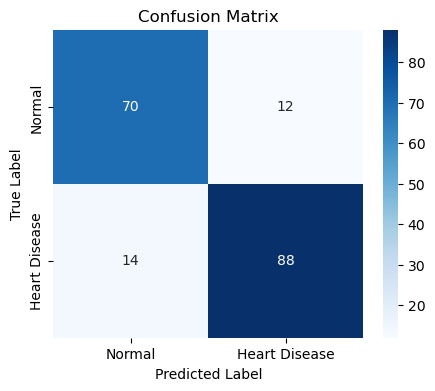

In [45]:
cm = confusion_matrix(y_test, test_prediction)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Heart Disease"], yticklabels=["Normal", "Heart Disease"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()